# Trabalho #3 - Redes Complexas

Nesse trabalho você vai desenvolver uma RNA para realizar uma tarefa de geração de imagem. A tarefa consiste em gerar um nariz para um rosto de uma pessoa. Assim, dada uma imagem de um rosto de uma pessoa com uma máscara cobrindo o nariz, a RNA deve gerar uma imagem desse rosto com um nariz adequado. 

Esse trabalho consiste de uma aplicação real de redes neurais, que foi desenvolvida para a Faculdade de Odontologia da USP para permitir criar próteses nasais adequadas para pacientes que perderam o nariz. 

Para realizar essa tarefa iremos usar uma rede neural tipo residual.

## Coloque os nomes e RAs dos alunos que fizeram esse trabalho

Nome e número dos alunos da equipe:

Aluno 1: Igor Amaral Correa 20.83992-8

Aluno 2: 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%cd /content/drive/My Drive/RNC_T3
!ls

/content/drive/My Drive/RNC_T3
data64.h5  faces1.png  faces2.png  mask512.jpg


Em primeiro lugar é necessário importar alguns pacotes do Python que serão usados ao longo nesse trabalho:

- numpy: pacote de cálculo científico com Python
- matplotlib: biblioteca para gerar gráficos em Python
- h5py: biblioteca que permite ler e escrever arquivos no formato h5
- skimage: bilioteca para porcessar imagens
- TensorFlow

In [0]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
import tensorflow as tf

%matplotlib inline

## 1 - Visão geral do problema ##

O objetivo desse problema é desenvolver uma RNA que recebe como entrada uma imagem de um rosto com uma máscara preta cobrindo a região do nariz e gera uma nova imagem do rosto com um nariz adequado. 

O conjunto de dados usado nesse trabalho foi criado usando o banco de imagens de celebridades CELEBA-HQ-512, que possui 30.000 imagens de rostos de celebridades com resolução 512 por 512. Esse banco de dados pode ser obtido no link: https://github.com/tkarras/progressive_growing_of_gans.

Nesse trabalho iremos utilizar somente 1.800 imagens com dimensão reduzida para 64 por 64. Essa redução no número e na dimensão das imagens é feita somente para podermos realizar o treinamento da RNA em um tempo razoável.

As figuras abaixo mostram dois exemplos do conjunto de dados.

<img src="Faces1.png">

<img src="Faces2.png">


## 2 - Dados de treinamento

As imagens que iremos utilizar nesse trabalho já foram processadas de forma a criar o par de imagens de entrada e saída. As imagens estão no arquivo data64.h5.

Características dos dados:

- As imagens são coloridas e estão no padrão RGB;
- Cada imagem de entrada e de saída tem dimensão de 64x64x3;
- As imagens já foram normalizadas, então, o valor da intensidade luminosa de cada pixels é um número real entre 0 e 1;
- As imagens de entrada consistem em rostos de celebridades com a máscara preta cobrindo o nariz;
- As imagens de saída consistem nos rostos das celebridades.


### 2.1 - Leitura dos dados

Para iniciar o trabalho é necessário ler o arquivo de dados. Assim, execute o código da célula abaixo para ler o arquivo de dados.

**Importante:**
Para obter o arquivo de dados você deve copiar o link abaixo no seu browser e dar o download. Após isso colocar o arquivo em algum diretório que possa ser usado.
https://drive.google.com/open?id=1G5Ot0SaVhyoSg3sEpDtMwTCh_nLtFu7b

In [0]:
# Abre arquivo de dados data64.h5
hf = h5py.File('data64.h5','r')

# Le imagens do arquivo. As imagens estão em um dicionário, sendo que os dados e entrada e saída estão separados, 
# assim como os dados de treinamento, validação e teste.
x_train0 = np.array(hf.get('x_train'))
y_train0 = np.array(hf.get('y_train'))
x_val0 = np.array(hf.get('x_val'))
y_val0 = np.array(hf.get('y_val'))
x_test0 = np.array(hf.get('x_test'))
y_test0 = np.array(hf.get('y_test'))

x_train = x_train0[:1200]
y_train = y_train0[:1200]
x_val = x_val0[:300]
y_val = y_val0[:300]
x_test = x_test0[:300]
y_test = y_test0[:300]

img_size = x_train.shape[1:4]

# Feche arquivo de dados
hf.close()

# Imprime dimensão dos conjuntos de dados
print('Dimensão dos dados de treinamento (entrada/saída) =', x_train.shape, y_train.shape)
print('Dimensão dos dados de validação (entrada/saída) =', x_val.shape, y_val.shape)               
print('Dimensão dos dados de teste (entrada/saída) =1', x_test.shape, y_test.shape)

Dimensão dos dados de treinamento (entrada/saída) = (1200, 64, 64, 3) (1200, 64, 64, 3)
Dimensão dos dados de validação (entrada/saída) = (300, 64, 64, 3) (300, 64, 64, 3)
Dimensão dos dados de teste (entrada/saída) =1 (300, 64, 64, 3) (300, 64, 64, 3)


Pela dimensão dos tensores com os dados de treinamento, validação e teste temos:

- 1200 imagens de treinamento com dimensão de 64x64x3 pixels;
- 300 imagens de validação com dimensão de 64x64x3 pixels;
- 300 imagens de teste com dimensão de 64x64x3 pixels.


Execute a célula a seguir para visualizar um exemplo do banco de dados. Altere o valor da variável 'index' e execute a célula novamente para visualizar mais exemplos diferentes.

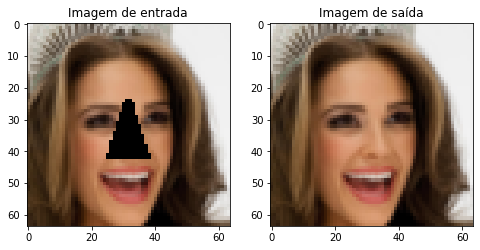

In [0]:
# Mostra exemplo de imagem de entrada e saída

# Trocar o valor de index para mostrar outras imagens
index = 0
f, pos = plt.subplots(1, 2, figsize=(8, 8))
pos[0].imshow(x_train[index])
pos[0].set_title('Imagem de entrada')
pos[1].imshow(y_train[index])
pos[1].set_title('Imagem de saída')
plt.show()


## 3 - RNA convolucional

Nesse trabalho você irá usar uma RNA convolucional residual conforme visto em aula. Então a primeira etapa é criar um bloco reasidual para depois unir vários blocos em uma RNA.

**Importante:** a saída dessa RNA é uma imagem com a mesma dimensão da imagem de entrada, assim, a dimensão da imagem original deve ser preservada em todas as camadas convolucionais.

### Exercício #1: Criar uma função que define um bloco residual

Na célula abaixo crie um bloco residual exatamente igual ao visto em aula. Não se esqueca de incluir a opção `padding='same'` nas camadas convolucionais que as saídas tenham a mesma dimensão.

In [0]:
# PARA VOCÊ FAZER: Função bloco_residual

from tensorflow.keras import layers

def bloco_residual(X, n, dim):
    """`
    Entradas: 
        X = tensor de entrada 
        n = número de filtros
        dim = dimensão dos filtros
    
    Saída:
        A2 -> tensor de saída
    """
    # Camadas convolucionais
    ### COMECE AQUI ### (≈ 2 linhas)    
    A1 = layers.Conv2D( n, dim, strides=1, padding='same', activation='relu' )(X)
    Z2 = layers.Conv2D( n, dim, strides=1, padding='same', activation='linear' )(A1)
    ### TERMINE AQUI ###
    
    # Adiciona os dois ramos e aplica ativação ReLu
    ### COMECE AQUI ### (≈ 2 linhas)    
    ZX = layers.Add()( [Z2, X])  
    A2 = layers.Activation( 'relu' )(ZX)
    ### TERMINE AQUI ###
    
    # Retorna saída
    return A2

### Exercício #2: Criar uma RNA com blocos residuais

Na célula abaixo crie uma RNA com 6 blocos residuais. Use o bloco residual definido na função `bloco_residual` criada no exercício #1. Note que antes de um bloco residual pode ser necessária uma camada convolucional para ajustar a dimensão dos tensores para não ter problema na hora de realizar a soma dentro do bloco residual.

As configuração dessa rede é a seguinte:

- Camada de entrada que recebe as imagens de dimensão 64x64x3
- Camada convolucional: 128 filtros de dimensão 5x5, ativação relu
- 1o bloco residual: 128 filtros de dimensão 5x5
- Camada convolucional: 256 filtros de dimensão 5x5, ativação relu
- 2o e 3o blocos residuais: 256 filtros de dimensão 5x5
- Camada convolucional: 128 filtros de dimensão 5x5, ativação relu
- 4o e 5o blocos residuais: 128 filtros de dimensão 5x5
- Camada convolucional: 64 filtros de dimensão 5x5, ativação relu
- 6o bloco residual: 64 filtros de dimensão 5x5
- Camada convolucional: 3 filtros de dimensão 5x5, ativação linear

Observe que todas as camadas convoluciionais devem ser com `padding='same'`. 

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 64, 64, 128)  9728        input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 64, 64, 128)  409728      conv2d_54[0][0]                  
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 64, 64, 128)  409728      conv2d_55[0][0]                  
____________________________________________________________________________________________

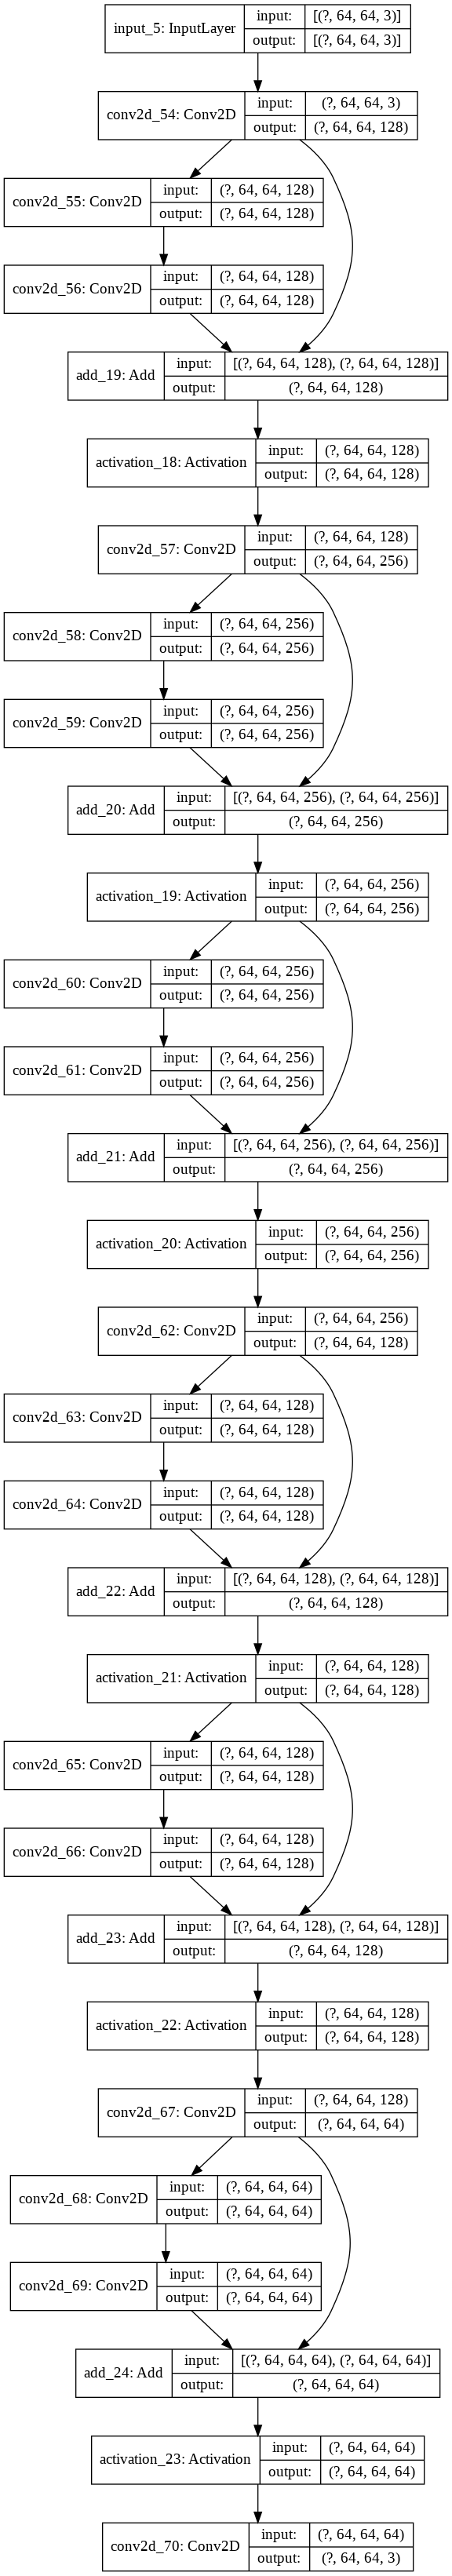

In [0]:
# PARA VOCÊ FAZER: Rede residual

from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.utils import plot_model

# Definição da dimensão da entrada e da camada de entrda (use camada tipo Input)
### COMECE AQUI ### (≈ 2 linhas)
xshape = x_train.shape[1:4]
x0 = Input( shape=xshape )
### TERMINE AQUI ###

### COMECE AQUI ### (≈ 11 linhas)    
# Camada convolucional para ajustar número de canais para poder ser somada dentro do bloco residual
x1 = layers.Conv2D( 128, (5,5), strides=1, padding='same', activation='relu' )(x0)

# Primeiro bloco residual com 128 filtros
x2 = bloco_residual( x1, 128, (5, 5) )

# Camada convolucional para ajustar número de canais para poder ser somada dentro do bloco residual
x3 = layers.Conv2D( 256, (5,5), strides=1, padding='same', activation='relu' )(x2)

# Segundo bloco residual com 256 filtros
x4 = bloco_residual( x3, 256, (5, 5) )

# Terceiro bloco residual com 256 filtros
x5 = bloco_residual( x4, 256, (5, 5) )

# Camada convolucional para ajustar número de canais para poder ser somada dentro do bloco residual
x6 = layers.Conv2D( 128, (5,5), strides=1, padding='same', activation='relu' )(x5)

# Quarto bloco residual com 128 filtros
x7 = bloco_residual( x6, 128, (5, 5) )

# Quinto bloco residual com 128 filtros
x8 = bloco_residual( x7, 128, (5, 5) )

# Camada convolucional para ajustar número de canais para poder ser somada dentro do bloco residual
x9 = layers.Conv2D( 64, (5,5), strides=1, padding='same', activation='relu' )(x8)

# Sexto bloco residual com 64 filtros
x10 = bloco_residual( x9, 64, (5, 5) )

# Camada convolutional para acertar profundidade da imagem resultante no padrão RGB
x11 = layers.Conv2D( 3, (5,5), strides=1, padding='same', activation='relu' )(x10)
### TERMINE AQUI ###

# Criação da RNA
### COMECE AQUI ### (≈ 1 linha)
rna = Model(x0, x11)
### TERMINE AQUI ###

# Mostra resumo da RNA
rna.summary()

# Se quiser visualizar o gráfico da rede criada tire o comentário da linha de baixo. Esse comando cria um gráfico 
# da rede e salva no arquivo rna.png
plot_model(rna, to_file='rna.png', show_shapes=True)    


**Saída esperada:** 

    Model: "model"
    __________________________________________________________________________________________________
    Layer (type)                    Output Shape         Param #     Connected to                     
    ==================================================================================================
    input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
    __________________________________________________________________________________________________
    conv2d (Conv2D)                 (None, 64, 64, 128)  9728        input_1[0][0]                    
    __________________________________________________________________________________________________
    conv2d_1 (Conv2D)               (None, 64, 64, 128)  409728      conv2d[0][0]                     
    __________________________________________________________________________________________________
    conv2d_2 (Conv2D)               (None, 64, 64, 128)  409728      conv2d_1[0][0]                   
    __________________________________________________________________________________________________
    add (Add)                       (None, 64, 64, 128)  0           conv2d_2[0][0]                   
                                                                     conv2d[0][0]                     
    __________________________________________________________________________________________________
    activation (Activation)         (None, 64, 64, 128)  0           add[0][0]                        
    __________________________________________________________________________________________________
    conv2d_3 (Conv2D)               (None, 64, 64, 256)  819456      activation[0][0]                 
    __________________________________________________________________________________________________
    conv2d_4 (Conv2D)               (None, 64, 64, 256)  1638656     conv2d_3[0][0]                   
    __________________________________________________________________________________________________
    conv2d_5 (Conv2D)               (None, 64, 64, 256)  1638656     conv2d_4[0][0]                   
    __________________________________________________________________________________________________
    add_1 (Add)                     (None, 64, 64, 256)  0           conv2d_5[0][0]                   
                                                                 conv2d_3[0][0]                   
    __________________________________________________________________________________________________
    activation_1 (Activation)       (None, 64, 64, 256)  0           add_1[0][0]                      
    __________________________________________________________________________________________________
    conv2d_6 (Conv2D)               (None, 64, 64, 256)  1638656     activation_1[0][0]               
    __________________________________________________________________________________________________
    conv2d_7 (Conv2D)               (None, 64, 64, 256)  1638656     conv2d_6[0][0]                   
    __________________________________________________________________________________________________
    add_2 (Add)                     (None, 64, 64, 256)  0           conv2d_7[0][0]                   
                                                                     activation_1[0][0]               
    __________________________________________________________________________________________________
    activation_2 (Activation)       (None, 64, 64, 256)  0           add_2[0][0]                      
    __________________________________________________________________________________________________
    conv2d_8 (Conv2D)               (None, 64, 64, 128)  819328      activation_2[0][0]               
    __________________________________________________________________________________________________
    conv2d_9 (Conv2D)               (None, 64, 64, 128)  409728      conv2d_8[0][0]                   
    __________________________________________________________________________________________________
    conv2d_10 (Conv2D)              (None, 64, 64, 128)  409728      conv2d_9[0][0]                   
    __________________________________________________________________________________________________
    add_3 (Add)                     (None, 64, 64, 128)  0           conv2d_10[0][0]                  
                                                                     conv2d_8[0][0]                   
    __________________________________________________________________________________________________
    activation_3 (Activation)       (None, 64, 64, 128)  0           add_3[0][0]                      
    __________________________________________________________________________________________________
    conv2d_11 (Conv2D)              (None, 64, 64, 128)  409728      activation_3[0][0]               
    __________________________________________________________________________________________________
    conv2d_12 (Conv2D)              (None, 64, 64, 128)  409728      conv2d_11[0][0]                  
    __________________________________________________________________________________________________
    add_4 (Add)                     (None, 64, 64, 128)  0           conv2d_12[0][0]                  
                                                                     activation_3[0][0]               
    __________________________________________________________________________________________________
    activation_4 (Activation)       (None, 64, 64, 128)  0           add_4[0][0]                      
    __________________________________________________________________________________________________
    conv2d_13 (Conv2D)              (None, 64, 64, 64)   204864      activation_4[0][0]               
    __________________________________________________________________________________________________
    conv2d_14 (Conv2D)              (None, 64, 64, 64)   102464      conv2d_13[0][0]                  
    __________________________________________________________________________________________________
    conv2d_15 (Conv2D)              (None, 64, 64, 64)   102464      conv2d_14[0][0]                  
    __________________________________________________________________________________________________
    add_5 (Add)                     (None, 64, 64, 64)   0           conv2d_15[0][0]                  
                                                                     conv2d_13[0][0]                  
    __________________________________________________________________________________________________
    activation_5 (Activation)       (None, 64, 64, 64)   0           add_5[0][0]                      
    __________________________________________________________________________________________________
    conv2d_16 (Conv2D)              (None, 64, 64, 3)    4803        activation_5[0][0]               
    ==================================================================================================
    Total params: 11,076,099
    Trainable params: 11,076,099
    Non-trainable params: 0
    __________________________________________________________________________________________________

## 4 - Função de custo e métrica


### Máscara

Para implementar essa função de custo é necessário usar uma imagem com a máscara. Essa máscara está no arquivo mask512.h5 e tem dimensão 512x512x3. Execute a célula abaixo para visualizar a máscara utilizada, já redimensionada para 64x64x3 pixels.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


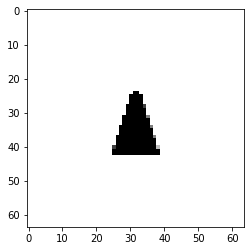

In [0]:
mask0 = imread('mask512.jpg')
mask0 = np.array(mask0)
mask = resize(mask0, (64, 64, 3), preserve_range=True)
plt.imshow(mask)
plt.show()

### Função de custo

Como a RNA processa toda a imagem e não somente a região escondida pela máscara que se deseja reconstruir, então, a função de custo deve diferenciar a reconstrução da parte que contém a máscara (o triângulo que omite o nariz) das outras regiões da imagem. Para isso usa-se uma função de custo desenvolvida por Liu et al. (2018) na qual são  atribuídos pesos maiores para os pixels internos à máscara e pesos menores para os pixels fora da máscara. A função de custo $L_{total}$ é definida por:

$$L_{total} = L_{valid} + 10L_{hole}$$

onde,

$$L_{hole} = \frac {1}{N} \sum_{i=1}^{N}(1 - m_i)|y_{orig(i)} - y_{prev(i)}|$$

$$L_{valid} = \frac {1}{N} \sum_{i=1}^{N}(m_i)|y_{orig(i)} - y_{prev(i)}|$$
 
onde $m_i$ é o valor do pixel $i$ da máscara, $y_{orig(i)}$ é o valor do pixel $i$ da imagem original sem a máscara, $y_{prev(i)}$ é o valor do pixel $i$ da imagem reconstruída pela rede e $N$ é o número total de pixels das imagens, que no caso é 64*64*3.

Nota-se que na função $L_{hole}$ são considerados somente os pixels que estão dentro da região da máscara e na função $L_{valid}$ são considerados os pixels externos à máscara. Os pesos atribuídos para $L_{valid}$ e $L_{hole}$ na função de custo total $L_{total}$ foram determinados por meio de uma processo de otimização usando 100 imagens.

**Referência:**
Liu ewt al., Image Inpainting for Irregular Holes Using. Computer Vision Foundation.Liu, et al., 2018. (http://openaccess.thecvf.com/content_ECCV_2018/html/Guilin_Liu_Image_Inpainting_for_ECCV_2018_paper.html)

Execute a célula abaixo para definir as funções $L_{hole}$ e $L_{valid}$ para serem usadas na função de custo $L_{total}$.


In [0]:
# Função L1, usadas pelas funções L_hole e L_ valid para calcula o erro absoluto médio de dois tensores.

import tensorflow.keras.backend as K

def l1(y_true, y_pred):
    """Calculate the L1 loss used in loss calculations"""
    return K.mean(K.abs(y_pred - y_true))
 
# Função L_hole
def loss_hole(mask, y_true, y_pred):
    """Pixel L1 loss within the mask"""
    return l1((1-mask) * y_true, (1-mask) * y_pred)
    
# Função L_valid    
def loss_valid(mask, y_true, y_pred):
    """Pixel L1 loss outside the mask"""
    return l1(mask * y_true, mask * y_pred)

### Exercício #3: Função de custo 

Usando as funções $L_{valid}$ e $L_{hole}$ complete a célula abaixo para implementar a função de custo $L{total}$ conforme as equações definidas acima.


In [0]:
# PARA VOCÊ FAZER: Função de custo L_total

def L_total(y_true, y_pred):
    """
    Entradas:
        y_true = saída desejada 
        y_pred = saída calculada pela rede
        
    Retorna:
        Função de custo Ltotal
    """         
    
    # ler máscara e redimensiona para 64x64
    mask0 = imread('mask512.jpg')
    mask0 = np.array(mask0)
    mask = resize(mask0, (64, 64, 3), preserve_range=True)/255.
  
    # Calcula componentes da função de custo e depois a função de custo total
    # (use as funções definidas na célula de código anterior)
    ### COMECE AQUI ### (≈ 3 linhas)  
    l1 = loss_hole( mask, y_true, y_pred )
    l2 = loss_valid( mask, y_true, y_pred )
    Ltotal = l2 + 10 * l1
    ### TERMINE AQUI ### 

    # Return loss function
    return Ltotal

Execute a célula abaixo para testar a sua função de custo $L_{total}$.

In [0]:
# Define imagem de teste
index = 0

# Expande número de eixos para incluir 1o eixo dos exemplos
yorig = np.expand_dims(y_train[index], axis=0)
yprev = np.expand_dims(x_train[index], axis=0)

# Calcula função de custo
loss = L_total(yorig, yprev)

# Abre sessão do TensorFlow para excutar a função L_total
print('L_total = ', format(loss))

L_total =  0.22633830550449346


**Saída esperada:**

    L_total = 0.22633828

### Métrica

A métrica adequada para esse problema é a relação sinal ruído, geralmente abreviada por PSNR, ver https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio. A PSNR define a relação entre o valor máximo de um sinal e o ruído presente no sinal, que afeta a sua fidelidade. 

PSNR é definida em termos da base logaritmica de decibel, sendo mais fácilmente entendida usando o erro quadrático médio (MSE), dado pela seguinte equação: 

$$MSE = \frac {1}{N} \sum_{i=1}^{N}[y_{orig(i)} - y_{prev(i)}]^{2}$$

onde $y_{orig(i)}$ é o valor do pixel $i$ da imagem original, $y_{prev(i)}$ é o valor do pixel $i$ da imagem gerada pela rede e $N$ é o número total de pixels das imagens. Assim, o $MSE$ representa a média do erro quadrático entre os valores dos pixels das imagens original e gerada pela rede.

Tendo o $MSE$ a $PSNR$ é definida por:

$$PSNR = 10 .log_{10}({\frac {max^2}{MSE}}) = 20 .log_{10}(max) - 10 .log_{10}(MSE)$$

onde $max$ é o valor máximo que um pixel das imagens pode assumir. No caso as imagens estão normalizadas entre 0 e 1, ou seja, $max = 1$, mas como $log_{10}(1) = 0$, então, a equação acima é simplificada para:

$$PSNR = -10.log_{10}(MSE)$$

Note que se a imagem reconstruída for igual a imagem original, então, $PSNR = \infty$, ou seja, quanto melhor for a imagem reconstruída maior o valor de PSNR.

### Exercício #4: Métrica PSNR 

A métrica PSNR não está disponível no Keras então temos que implementá-la. Assim, na célula abaixo crie a função que calcula essa métrica de acordo com a equação definida acima. Observe que uma métrica do Keras deve receber como parâmetros a saída desejada e a saída calculada pela rede. Para implementar facilmente essa métrica você pode usar as funções `square`, `mean` e `log` da classe backend do Keras. 

Observe que a função `log` do keras calcula o logaritmo na base $e$, assim, para calcular o logaritmo de um número $x$ na base 10, deve-se fazer a mudança de base usando a seguinte equação:

$$log_{10}(x) = \frac {log_e(x)} {log_e(10)}$$

**Observação:**

Note que o TensorFlow-Keras Backend foi importado como K. Isso significa que para usar as funções do Keras é necessário escrever `K.function(...)`.

In [0]:
# PARA VOCÊ FAZER: Função da métrica PSNR

def PSNR(y_true, y_pred):
    """
    Entradas:
        y_true = saída desejada 
        y_pred = saída calculada pela rede
        
    Retorna:
        métrica exatidão
    """        
    # Define uma constante igual a 10.0 do mesmo tipo dos tensores de entrada para poder calcular log(10)
    tipo = y_true.dtype
    dez = tf.constant(10.0, dtype=tipo) 
     
    ### COMECE AQUI ### (≈ 2 linhas)     
    mse = K.mean(K.square(y_pred - y_true))
    psnr = -10*(K.log(mse) / K.log(dez))
    ### TERMINE AQUI ###

    return psnr

Execute a célula abaixo para testar a sua função PSNR.

In [0]:
import tensorflow as tf

# Define imagens
index = 0

# Expande eixos (1o eixo dos exemplos)
yorig = np.expand_dims(y_train[index], axis=0)
yprev = np.expand_dims(x_train[index], axis=0)

# Calcula PSNR
psnr = PSNR(yorig, yprev)

# Abre sessão do TensorFlow para excutar a função PSNR
print('PSNR = ', format(psnr))

PSNR =  18.41677174785432


**Saída esperada:**

    PSNR = 18.41677
    
Veja o que acontece com o resultado da métrica PSNR se no lugar de `x_train[index]` você usar `y_train[index]`.    

## 5 - Compilação e treinamento da RNA

### Exercício #5: Compilação e treinamento da RNA

Agora você vai treinar a sua RNA usando o método de otimização ADAM. Assim, na célula abaixo, compile e treine a sua RNA usando os seguinte hiperparâmetros:

- taxa de aprendizado = 0,001;
- função de custo: L_total
- métrica: PSNR
- número de épocas = 50

Essa operação deve demorar pleo menos 20 minutos.

In [0]:
# PARA VOCÊ FAZER: Compilação e treinamento da RNA

from tensorflow.keras.optimizers import Adam

### COMECE AQUI ### (≈ 2 linhas)    
rna.compile(  optimizer=Adam(lr=0.001), loss=L_total, metrics=[PSNR] )
history = rna.fit( x_train, y_train, epochs=50, validation_data=( x_val, y_val ), verbose=1 )
### TERMINE AQUI ###   

Epoch 1/50
38/38 [==============================] - 13s 350ms/step - loss: 36.7893 - PSNR: 4.7576 - val_loss: 0.4359 - val_PSNR: 8.9153
Epoch 2/50
38/38 [==============================] - 12s 309ms/step - loss: 0.2647 - PSNR: 13.0398 - val_loss: 0.1649 - val_PSNR: 15.8583
Epoch 3/50
38/38 [==============================] - 12s 309ms/step - loss: 0.1462 - PSNR: 17.0736 - val_loss: 0.1279 - val_PSNR: 18.4576
Epoch 4/50
38/38 [==============================] - 12s 308ms/step - loss: 0.1183 - PSNR: 19.3857 - val_loss: 0.1112 - val_PSNR: 20.2066
Epoch 5/50
38/38 [==============================] - 12s 309ms/step - loss: 0.1007 - PSNR: 21.1578 - val_loss: 0.1080 - val_PSNR: 21.1645
Epoch 6/50
38/38 [==============================] - 12s 309ms/step - loss: 0.0905 - PSNR: 22.2019 - val_loss: 0.0885 - val_PSNR: 22.4748
Epoch 7/50
38/38 [==============================] - 12s 309ms/step - loss: 0.0832 - PSNR: 22.9690 - val_loss: 0.0861 - val_PSNR: 23.0696
Epoch 8/50
38/38 [========================

**Saída esperada:**

    Train on 1200 samples, validate on 300 samples
    Epoch 1/50
    1200/1200 [==============================] - 22s 18ms/sample - loss: 363.4275 - PSNR: 6.1513 - val_loss: 0.2705 - val_PSNR: 12.4118
    .
    .
    .
    Epoch 50/50
    1200/1200 [==============================] - 12s 10ms/sample - loss: 0.0392 - PSNR: 31.4102 - val_loss: 0.0457 - val_PSNR: 30.2404

## 6 - Resultados

Execute as células abaixo para visualizar os valores da função de custo e da métrica durante o treinamento.

In [0]:
# Verificação das variáveis salvas no processo de treinamento
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'PSNR', 'val_loss', 'val_PSNR'])

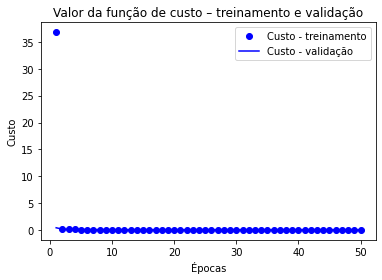

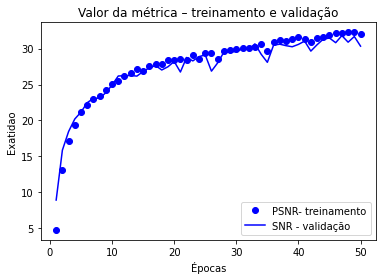

In [0]:
# Salva custos, métricas e epocas em vetores 
custo = history_dict['loss']
acc = history_dict['PSNR']
val_custo = history_dict['val_loss']
val_acc = history_dict['val_PSNR']

# Cria vetor de épocas
epocas = range(1, len(custo) + 1)

# Gráfico dos valores de custo
plt.plot(epocas, custo, 'bo', label='Custo - treinamento')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

# Gráfico dos valores da métrica
plt.plot(epocas, acc, 'bo', label='PSNR- treinamento')
plt.plot(epocas, val_acc, 'b', label='SNR - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

### Exercício #6: Resumo dos resultados

Usando o método evaluate, na célula abaixo calcule o valor da função de custo e da métrica para os dados de treinamento, validação e teste.

In [0]:
# PARA VOCÊ FAZER: Calcular resultados finais da função de custo e métrica após treinamento

### COMECE AQUI ### (≈ 3 linhas)    
custo_e_metricas_train = rna.evaluate( x_train, y_train, batch_size=1, verbose=1 )
custo_e_metricas_val = rna.evaluate( x_val, y_val, batch_size=1, verbose=1 )
custo_e_metricas_test = rna.evaluate( x_test, y_test, batch_size=1, verbose=1 )
### TERMINE AQUI ###

print('Resultados - dados treinamento:', custo_e_metricas_train)
print('Resultados - dados validação:', custo_e_metricas_val)
print('Resultados - dados teste:', custo_e_metricas_val)

300/300 [==============================] - 6s 21ms/step - loss: 0.0419 - PSNR: 30.8863
Resultados - dados treinamento: [0.03788001835346222, 31.385765075683594]
Resultados - dados validação: [0.042224712669849396, 30.780744552612305]
Resultados - dados teste: [0.042224712669849396, 30.780744552612305]


**Saída esperada:**

    1200/1200 [==============================] - 4s 3ms/sample - loss: 0.0425 - PSNR: 30.7296
    300/300 [==============================] - 1s 3ms/sample - loss: 0.0457 - PSNR: 30.2404
    300/300 [==============================] - 1s 3ms/sample - loss: 0.0455 - PSNR: 30.3217
    Resultados - dados treinamento: [0.04251373956600825, 30.729645]
    Resultados - dados validação: [0.04573282207051913, 30.240355]
    Resultados - dados teste: [0.04573282207051913, 30.240355]

### Visualização do resultado de um exemplo do conjunto de teste

Execute a célula abaixo para visualizar as imagens original e a reconstruída de um exemplo do conjunto de teste. Troque o valor da variável `index` para visualizar vários exemplos.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


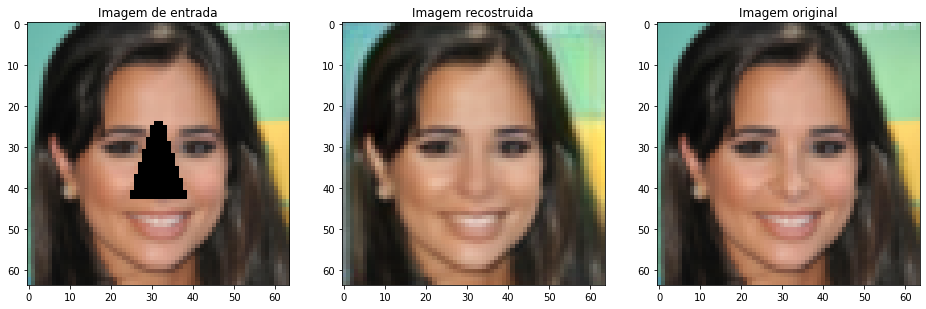

In [0]:
# Mostra o resultado de uma imagem

# Escolhe imagem e expande o número de eixos
index = 0
xindex = np.expand_dims(x_test[index], axis=0)

# Calcula imagem reconstruída pela RNA
y_pred = rna.predict(xindex)

# Mostra imagens 
f, pos = plt.subplots(1, 3, figsize=(16, 16))
pos[0].imshow(x_test[index])
pos[0].set_title('Imagem de entrada')
pos[1].imshow(y_pred[0])
pos[1].set_title('Imagem recostruida')
pos[2].imshow(y_test[index])
pos[2].set_title('Imagem original')
plt.show()